# Model Fit
The likelihood function (often simply called the *likelihood*) is the joint probability (or probability density) of observed data viewed as a function of the parameters of a statistical model. By combining the likelihood function with a code able to explore the parameter space of our model (or a *sampler*), we can determine the probability density of the model parameters given the data, or *posteriors*. The posteriors of our model effectively represent the final results of our analysis.

## Likelihood Function
We consider N observations of a variable $ \boldsymbol{y} = \{ y_i \}_{i=1,...,N} $, taken at times $\boldsymbol{t} = \{ t_i \} $, with associated measurement uncertainties $ \boldsymbol{\sigma} = \{ \sigma_i \} $. We wish to compare these to a model function $ m(t_i, \boldsymbol{\theta}) $ controlled by parameters $ \boldsymbol{\theta} = \{ \theta_j \}_{j=1,...,M} $.

Let us assume that the observations are given by:
$$ y_i = m(t_i, \theta) + \epsilon_i $$

where $ \epsilon_i $ is the measurement error, or noise, of the $ i^{th} $ observation.

Let us assume that $ \epsilon_i $ is drawn from a Gaussian distribution with mean 0 and variance $ \sigma_i^2 $:
$$ p(\epsilon_i) = \mathcal{N}(0, \sigma_i^2) \equiv \frac{1}{\sqrt{2 \pi} \sigma_i} \exp\left( -\frac{\epsilon_i^2}{2\sigma_i^2} \right) $$

Then the likelihood for the $ i^{th} $ observation is simply:
$$ \mathcal{L}_i(\boldsymbol{\theta}) \equiv p(y_i | \boldsymbol{\theta}) = \mathcal{N}(m_i, \sigma_i^2) = \frac{1}{\sqrt{2 \pi} \sigma_i} \exp\left[ -\frac{(y_i-m_i)^2}{2\sigma_i^2} \right] $$

We also assume that the noise is uncorrelated, or *white*, meaning that each $ \epsilon_i $ is drawn from its corresponding distribution, independently from the others. Then, the likelihood for the whole dataset $ \boldsymbol{y} $ is merely the product of the likelihoods for the individual observations:
$$ \mathcal{L}(\boldsymbol{\theta}) \equiv p(\boldsymbol{y} |\boldsymbol{\theta}) = \prod_{i=1}^{N} \left\{ \frac{1}{\sqrt{2 \pi} \sigma_i} \exp\left[ -\frac{(y_i-m_i)^2}{2\sigma_i^2} \right] \right\} $$

The natural logarithm of $ \mathcal{L} $ is equal to:
$$ \ln\mathcal{L} = -0.5N\ln(2\pi) - \sum_{i=1}^{N}\ln(\sigma_i) - 0.5 \chi^2 $$

Where $ \chi^2 $ is equal to the weighted sum of squared deviations:
$$ \chi^2 = \sum_{i=1}^{N} \frac{(y_i-m_i)^2}{\sigma_i^2} $$

The above equation can be rewritten as:
$$ \ln\mathcal{L} = -0.5[N\ln(2\pi) + \chi^2 + \sum_{i=1}^{N}\ln(\sigma_i^2)] $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
import pickle
%matplotlib widget

In [2]:
# -- TASTE data --
# Loading previously saved arrays with time (BJD_TDB) and flux (normalized and non-normalized).
# 'pickle.load()' loads python objects from the specified file.
taste_bjd_tdb = pickle.load(open('taste_bjdtdb.p','rb'))


differential_allref = pickle.load(open('differential_allref.p','rb'))
differential_allref_error = pickle.load(open('differential_allref_error.p','rb'))


# -- TESS data --
# Loading one sector's data for the same star, already filtered to remove bad data points.
# тут наш файл для нашей планеты
tess_sector23_dict = pickle.load(open('/Users/alina.zakareeva/Desktop/Lab 2/notebook_TESS/HATP12_TESS_sector23_filtered.p', 'rb'))
tess_bjd_tdb = tess_sector23_dict['time']
tess_normalized_flux = tess_sector23_dict['selected_flux']
tess_normalized_ferr = tess_sector23_dict['selected_flux_error']


# Parameter Definitions

- `params.t0`: Time of inferior conjunction

1. `params.per`: Orbital period of the planet, in days

2. `params.rp`: Scaled planetary radius, i.e., planet radius in units of stellar radii

3. `params.a`: Scaled semi-major axis, i.e., semi-major axis in units of stellar radii

4. `params.inc`: Orbital inclination in degrees

## TESS Specific Parameters

For TESS, we have to include two additional parameters for the limb darkening coefficients:

5. TESS limb darkening coefficient `u1`

6. TESS limb darkening coefficient `u2`

## TASTE Specific Parameters

For TASTE, we have to include again two additional parameters for the limb darkening coefficients, and three parameters for the coefficient of the _quadratic_ polynomial trend.

7. TASTE limb darkening coefficient `u1`

8. TASTE limb darkening coefficient `u2`

9. Zero-th order coefficient for the polynomial trend

10. First order coefficient for the polynomial trend

11. Second order coefficient for the polynomial trend

## Jitter Parameters

Finally, we add two extra parameters, called _jitter parameters_, which are not used by the model but are instead added in quadrature to estimate our errors. These parameters will compensate for any source of errors that we have not included in our estimates until now. An example can be found in this paper.

12. Jitter parameter for TESS data

13. Jitter parameter for TASTE data
```

In [4]:
theta = np.empty(14)

#params.t0 =  2459688.443452                      #time of inferior conjunction
#params.per =  4.3011975                      #orbital period
#params.rp = 0.1343                      #planet radius (in units of stellar radii)
#...


theta[0] = 2459685.398095  #time of inferior conjunction
theta[1] = 3.2130578        #orbital period
theta[2] = 0.1406         #planet radius (in units of stellar radii)
theta[3] = 11.77          #semi-major axis (in units of stellar radii)
theta[4] = 89.0           #orbital inclination (in degrees)
theta[5] = 0.55           # TESS LD coeff u1
theta[6] = 0.09           # TESS LD coeff u2
theta[7] = 0.70           # TASTE LD coeff u1
theta[8] = 0.05           # TASTE LD coeff u2
theta[9] = 0.245           # zero-th order coefficient for the polynomial trend
theta[10] = 0.0           # first order coefficient for the polynomial trend
theta[11] = 0.0           # second order coefficient for the polynomial trend
theta[12] = 0.0           # jitter parameter for TESS data
theta[13] = 0.0           # jitter parameter for TASTE data

In [5]:
import batman

params = batman.TransitParams()
params.t0 =  theta[0]                
params.per = theta[1]                    
params.rp =  theta[2]                 
params.a =   theta[3]                   
params.inc =  theta[4]    
params.ecc = 0.
params.w = 90. 
params.u = [theta[5] , theta[6]]
params.limb_dark = "quadratic"

m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_flux =m_tess.light_curve(params)          #calculates light curv

params.u = [theta[7] , theta[8]]
median_bjd = np.median(taste_bjd_tdb)
polynomial_trend = theta[9] + theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_flux = m_taste.light_curve(params) * polynomial_trend

Note how we multiply the model by the polynomial trend, rather than divide the data by it. The idea behind this choice is to include all possible effects in the model rather than work on the data. This approach will also avoid the extra step of dividing the associated errors by the polynomial trend. LEt's compare the data with our model:



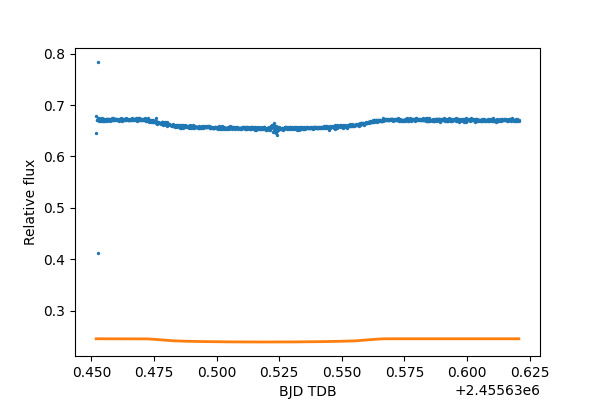

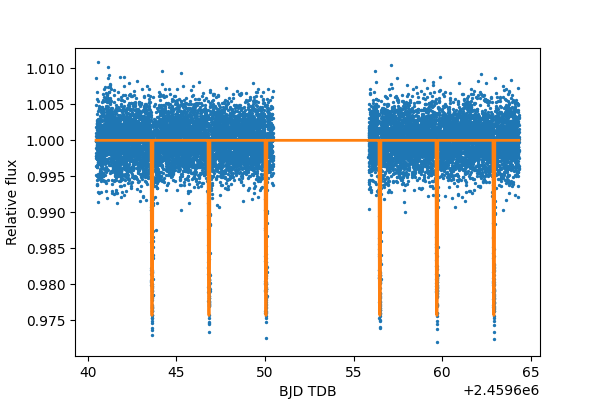

In [6]:
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_allref, s=2)
plt.plot(taste_bjd_tdb, taste_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2)
plt.plot(tess_bjd_tdb, tess_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

# Computing the Log-Likelihood

Let's compute the log-likelihood!

$$
\ln L = -0.5 \left[ N \ln 2\pi + \chi^2 + \sum_{i=1}^{N} \ln \sigma_i^2 \right]
$$

If we have two datasets, for the properties of the sum, the $ \chi^2 $ and the term with $ \ln \sigma_i^2 $ are equal to:

$$
\chi^2 = \chi^2_{\text{TESS}} + \chi^2_{\text{TASTE}}
$$

$$
\sum_{i=1}^{N} \ln \sigma_i^2 = \sum_{i=1}^{N_{\text{TESS}}} \ln \sigma_i^2 + \sum_{i=1}^{N_{\text{TASTE}}} \ln \sigma_i^2
$$

with $$ N = N_{\text{TESS}} + N_{\text{TASTE}} $$

The same considerations apply if you have several TESS sectors in addition to the TASTE observations, for example, data coming from TESS sectors 10, 11, and 12:

$$
\chi^2 = \chi^2_{\text{TESS sector 10}} + \chi^2_{\text{TESS sector 11}} + \chi^2_{\text{TESS sector 12}} + \chi^2_{\text{TASTE}}
$$

$$
\sum_{i=1}^{N} \ln \sigma_i^2 = \sum_{i=1}^{N_{\text{TESS sector 10}}} \ln \sigma_i^2 + \sum_{i=1}^{N_{\text{TESS sector 11}}} \ln \sigma_i^2 + \sum_{i=1}^{N_{\text{TESS sector 12}}} \ln \sigma_i^2 + \sum_{i=1}^{N_{\text{TASTE}}} \ln \sigma_i^2
$$

with $$ N = N_{\text{TESS sector 10}} + N_{\text{TESS sector 11}} + N_{\text{TESS sector 12}} + N_{\text{TASTE}} $$

The number by itself is not very useful. What we need to do is to find the combination of parameters that maximise the log-likelihood (and, conversely, minimise the $\chi^2$ To do so, we need to build a function that takes in input the parameter vector θ and gives us the log-likelihood value in output. 

In practice, we just have to assemble the last cells' operations inside a function.

In [7]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
    tess_flux =m_tess.light_curve(params)          #calculates light curv

    params.u = [theta[7] , theta[8]]
    median_bjd = np.median(taste_bjd_tdb)
    polynomial_trend = theta[9]+theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

    m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
    taste_flux = m_taste.light_curve(params) * polynomial_trend

    
    tess_errors_with_jitter = tess_normalized_ferr**2 + theta[12]**2
    
    taste_errors_with_jitter = differential_allref_error**2 + theta[13]**2

    N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

    chi2_tess = np.sum( (tess_normalized_flux-tess_flux)**2 / tess_errors_with_jitter)
    chi2_taste = np.sum( (differential_allref-taste_flux)**2 / taste_errors_with_jitter)

    sum_ln_sigma_tess = np.sum(np.log(tess_errors_with_jitter))
    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess + chi2_taste + sum_ln_sigma_tess + sum_ln_sigma_taste)
    return log_likelihood

print('log_likelihood', log_likelihood(theta))

log_likelihood -103044860.43992601


### Define the Prior

These are the limb darkening coefficients that I retrieved for my filters:

- Sloan r LD coefficients:  
  $$ u_1 = 0.58 \pm 0.05 $$  
  $$ u_2 = 0.18 \pm 0.10 $$

- TESS LD coefficients:  
  $$ u_1 = 0.35 \pm 0.03 $$  
  $$ u_2 = 0.23 \pm 0.08 $$

#### Incorporating Priors into the Posterior Computation

How do I incorporate this information in the computation of the posterior? The Bayes theorem says:

$$
P(x|D) = \frac{P(D|x) P(x)}{P(D)}
$$

Our sampler works by taking the natural logarithm of the likelihood, so priors can be included easily by adding the logarithm of the probability density function of the parameters over which we want to impose a prior.

Depending on how much you trust your prior, you can keep the error estimate as predicted from theory or inflate the error associated with the median value according to other considerations. For example, Patel & Espinoza (2022) argue that the error associated with a theoretical estimate of the limb darkening coefficients should be at least 0.1.

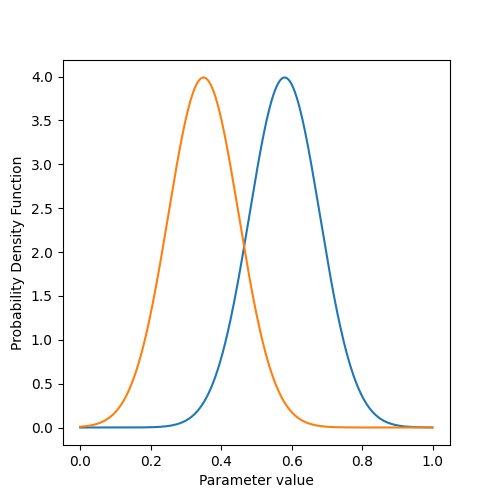

In [8]:
# prior on c1: 0.59 \pm 0.10
from scipy import stats

x_range=np.arange(0.00, 1.00, 0.001)
y1_plot = stats.norm.pdf(x_range, loc=0.58, scale=0.10)
y2_plot = stats.norm.pdf(x_range, loc=0.35, scale=0.10)
plt.figure(figsize=(5,5))
plt.plot(x_range, y1_plot)
plt.plot(x_range, y2_plot)
plt.xlabel('Parameter value')
plt.ylabel('Probability Density Function')
plt.show()

To correctly assign the prior, we need to keep track of the index associated with the parameters with explicit prior. 

Keep in mind that all parameters will have some kind of prior. If not explicitly stated, the prior is uniform, i.e., a constant value for the probability density distribution.

In [9]:
theta[5] = 0.55           # TESS LD coeff u1
theta[6] = 0.09           # TESS LD coeff u2
theta[7] = 0.70           # TASTE LD coeff u1
theta[8] = 0.05           # TASTE LD coeff u2

def log_prior(theta):
    prior = 0.00
    prior+= np.log(stats.norm.pdf(theta[5], loc=0.35, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[6], loc=0.23, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[7], loc=0.58, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[8], loc=0.18, scale=0.10))
    return prior

### Define the boundaries

Setting boundaries for our parameters is not strictly necessary for the sampler we use, but could be essential for other samplers. Generally, defining parameter space boundaries is beneficial as it prevents exploring unrealistic parameter combinations, such as negative periods or radii

The **boundaries are represented as a two-dimensional array**, where one dimension corresponds to the number of model parameters and the other dimension is two. This format makes it easy to verify if the θ array falls within the specified boundaries.

In [10]:
theta[0] = 2459685.398095  #time of inferior conjunction
theta[1] = 3.2130578        #orbital period
theta[2] = 0.1406         #planet radius (in units of stellar radii)
theta[3] = 11.77          #semi-major axis (in units of stellar radii)
theta[4] = 89.0           #orbital inclination (in degrees)
theta[5] = 0.55           # TESS LD coeff u1
theta[6] = 0.09           # TESS LD coeff u2
theta[7] = 0.70           # TASTE LD coeff u1
theta[8] = 0.05           # TASTE LD coeff u2
theta[9] = 0.245           # zero-th order coefficient for the polynomial trend
theta[10] = 0.0           # first order coefficient for the polynomial trend
theta[11] = 0.0           # second order coefficient for the polynomial trend
theta[12] = 0.0           # jitter parameter for TESS data
theta[13] = 0.0           # jitter parameter for TASTE data


boundaries = np.empty([2, len(theta)])

boundaries[:,0] = [theta[0]-0.5, theta[0]+0.5]
boundaries[:,1] = [theta[1]-0.5, theta[1]+0.5]
boundaries[:,2] = [0.0, 0.5]
boundaries[:,3] = [0.0, 20.]
boundaries[:,4] = [0.00, 90.0]
boundaries[:,5] = [0.00, 1.0]
boundaries[:,6] = [0.00, 1.0]
boundaries[:,7] = [0.00, 1.0]
boundaries[:,8] = [0.00, 1.0]
boundaries[:,9] = [0.00, 1.0]
boundaries[:,10] = [-1.0, 1.0]
boundaries[:,11] = [-1.0, 1.0]
boundaries[:,12] = [0.0, 0.05]
boundaries[:,13] = [0.0, 0.05]

If θ is outside the range, the log_probability will be -np.inf, and the sampler will reject the step. Otherwise, the sum of log_likelihood and log_prior will be computed

In [11]:
def log_probability(theta):
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_prob = log_prior(theta)

    log_prob += log_likelihood(theta)
    return log_prob

In [12]:
print('log_probability', log_probability(theta))


log_probability -103044859.45033978


### Running the MCMC sample

To run emcee, we need to define:

* the number of walkers: nwalkers
* the number of steps: nsteps
* the number of parameters: ndim


The number of walkers needs to be at least twice the number of parameters for the algorithm to work properly (this is a specific requirement of the affine invariant MCMC). The number of steps must be long enough for the chains to converge and mix. Note that:

* increasing the walker will make each iteration slower
* increasing the steps will make the total time longer

In [13]:
nwalkers = 50
nsteps = 20000
ndim = len(theta)

import emcee

We also need to provide a starting point for the MCMC. 

We can safely use the theta that we have built earlier, with a caveat: the sampler requires each chain to be initialized at a slightly different position with respect to the other, so we are going to build an array with shape (nwalkers, ndim) by perturbing our starting point θ by a small value. 

Since most of our starting values correspond to their lower boundary, we impose a positive perturbation for all variables (we could be selective, but the effort is not worth it).

In [14]:
#We initialize the walkers in a tiny Gaussian ball around our approximate result
starting_point = theta + np.abs(1e-5 * np.random.randn(nwalkers, ndim))

In [ ]:
from multiprocessing import Pool


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    sampler.run_mcmc(starting_point, nsteps, progress=True)

In [17]:
pickle.dump(sampler, open('emcee_sampler_first_run.p','wb'))

AttributeError: you must run the sampler with 'store == True' before accessing the results

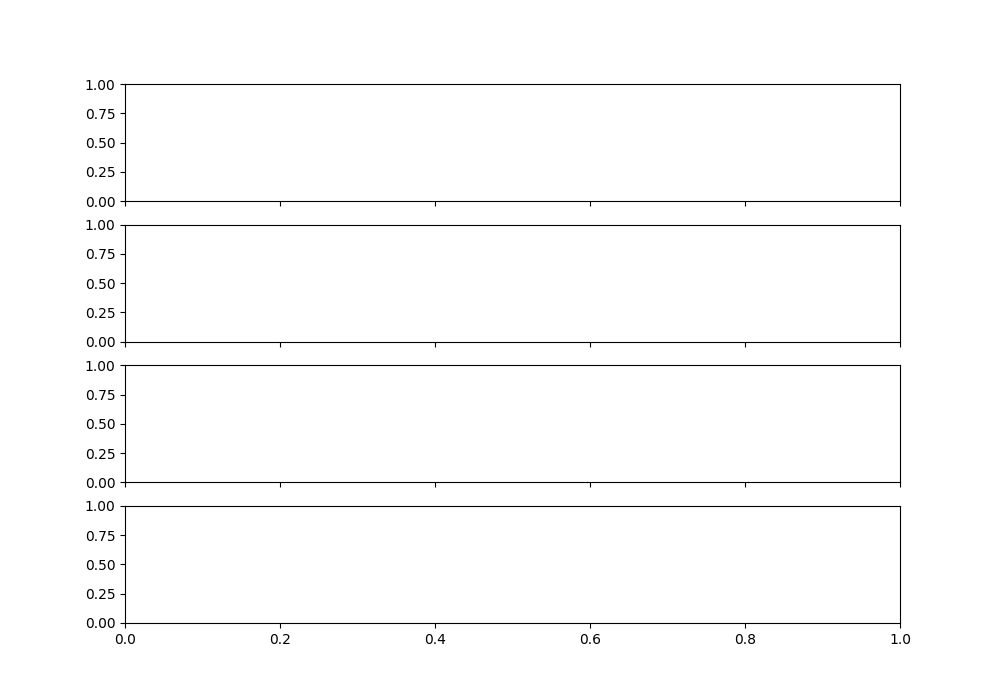

In [18]:
sampler = pickle.load(open('emcee_sampler_first_run.p','rb'))

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Tc", "P", "Rp/Rs", "a/Rs"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");